## Text Translation from Hindi to English
Implementin a neural network to translate from hindi to english

In [37]:
from io import open
import re
import random
import unicodedata

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Each word in a language is represented as a `one hot encoding`. Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

In [38]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [39]:
def readLangs():
    lines = open('hin-eng/hin.txt', encoding='utf-8').read().strip().split('\n')
    pairs = []
    for l in lines:
        pair = l.split('\t')
        pair = pair[:2]
        pair.reverse()
        pairs.append(pair)
    input_lang = Lang('hin')
    output_lang = Lang('eng')
    return input_lang, output_lang, pairs

In [40]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData()
print(random.choice(pairs))

['टॉम ने कहा की उन्हें नहीं लगा की गर्मी से मैरी परेशान हो रही थी ।', "Tom said he didn't think the heat bothered Mary."]


### The Seq2Seq Model
A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps.

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

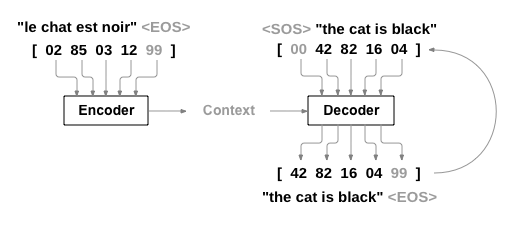

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.  

### The Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

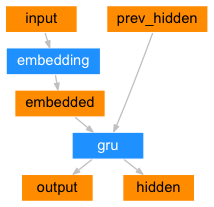

In [41]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.embedding(input)
        output = self.dropout(embedded)
        output, hidden = self.gru(output)
        return output, hidden

### The Decoder
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Simple Decoder
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

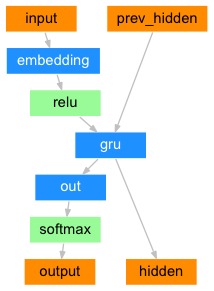

In [42]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_hidden, encoder_outputs, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) 
                '''
`target_tensor[:, i]` is indexing into the `target_tensor`. The `:` means we're taking all elements along the first dimension, and `i` means we're taking the `i`-th element along the second dimension. The result is a 1-D tensor that contains all elements from the `i`-th column of `target_tensor`.
So, `decoder_input` is a 2-D tensor that contains the `i`-th column of `target_tensor`, and its shape is `(n, 1)`, where `n` is the number of rows in `target_tensor`.'''
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(1).detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        out = self.embedding(input)
        out = F.relu(out)
        out, hidden = self.gru(out)
        out = self.out(out)
        return out, hidden


### Attention Decoder
If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

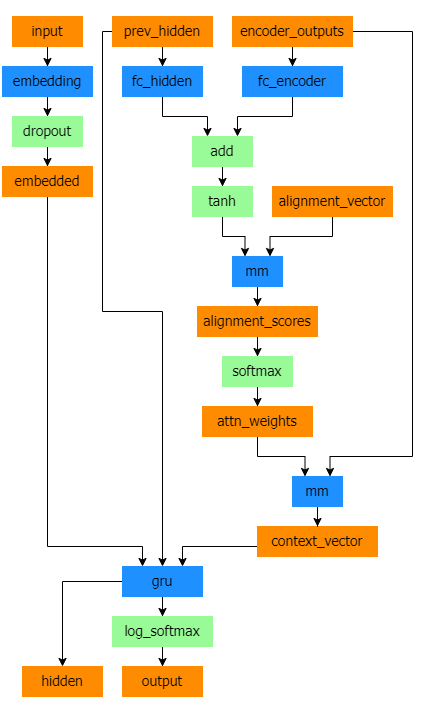

Bahdanau attention, also known as additive attention, is a commonly used attention mechanism in sequence-to-sequence models, particularly in neural machine translation tasks. It was introduced by Bahdanau et al. in their paper titled Neural Machine Translation by Jointly Learning to Align and Translate. This attention mechanism employs a learned alignment model to compute attention scores between the encoder and decoder hidden states. It utilizes a feed-forward neural network to calculate alignment scores.


In [43]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        
        return context, weights

In [44]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
    
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attention = []
        
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output)
            attention.append(attn_weights)
            
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
            
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attention = torch.cat(attention, dim=1)
        
        return decoder_outputs, decoder_hidden, attention
    
    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weight = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        
        return output, hidden, attn_weight
        

In [45]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    
def getDataLoader(batch_size):
    input_lang, output_lang, pairs = prepareData()
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    
    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = [input_lang.word2index[word] for word in inp.split(' ')]
        tgt_ids = [output_lang.word2index[word] for word in tgt.split(' ')]
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        '''
input_ids is a list of n size with each element a list of MAX_LENGTH size
so we are accessing the idx-th value of input_ids and then set first len(inp_ids) values with the array of values of inp_ids
        '''
        target_ids[idx, :len(tgt_ids)] = tgt_ids
        
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader
    

### Training the Model
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [46]:
def train(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        encoder_output, encoder_hidden = encoder(input_tensor)
        decoder_output, _, _ = decoder(encoder_output, encoder_hidden, target_tensor)
        
        loss = loss_fn(decoder_output.view(-1, decoder_output.size(-1)), target_tensor.view(-1))
        
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss+=loss.item()
    
    return total_loss/len(dataloader)

In [47]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)
        
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        
        decoded_words = []
        
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
        
        return decoded_words, decoder_attn
        

In [48]:
hidden_size = 128
batch_size = 32
NUM_EPOCHS = 80
print_every = 10
lr = 0.001

input_lang, output_lang, train_dataloader = getDataLoader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

loss_fn = nn.NLLLoss()
cur_loss = 0
losses = []


for epoch in range(1, NUM_EPOCHS+1):
    loss = train(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn)
    cur_loss += loss
    if epoch%print_every == 0:
        losses.append(cur_loss/print_every)
        cur_loss = 0


NameError: name 'plt' is not defined

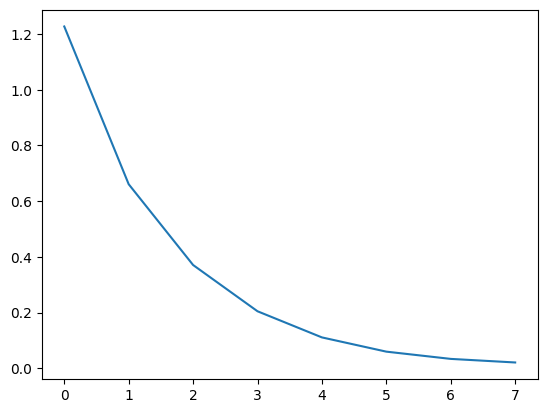

In [49]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses)

In [50]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [51]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> तुम उस ड्रेस में अच्छी लगती हो।
= You look nice in that dress.
< You really in here. <EOS>

> मैं कल गाँव जा रहा हूँ।
= I'm going to the village tomorrow.
< I'm going to the village tomorrow. <EOS>

> कल मौसम अच्छा होगा क्या?
= Will the weather be good tomorrow?
< the only fortune to danger. <EOS>

> जब पिताजी विदेश में थे, वे हमारे साथ चिट्ठी और फ़ोन से सम्पर्क करते थे।
= Father kept in touch with us by mail and telephone while he was overseas.
< into the flowers in the garden died of water. <EOS>

> पत्र किसको लिखा गया था?
= Who was the letter written to?
< Who was the speed of water. <EOS>

> वह काम करती रही।
= She kept on working.
< She knew the party. <EOS>

> मैं पैसे दूंगा।
= I'll pay.
< I'll pay. <EOS>

> इसे जल्द-से-जल्द ख़त्म करो ।
= Finish this as soon as possible.
< Finish this as soon as possible. <EOS>

> तुम्हें कैसा रस चाहिए?
= What kind of juice do you want?
< How much strawberries larger one? student student student student student student student time? you want? Ha